# Spectral analysis

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import drifters.utils as ut
import pynsitu as pin

In [2]:
from dask.distributed import Client

if True:
    from dask_jobqueue import PBSCluster

    cluster = PBSCluster()
    w = cluster.scale(jobs=2)  # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster

    cluster = LocalCluster()

client = Client(cluster)
client

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.68:8787/status,
Dashboard: http://10.148.0.68:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.68:39215,Workers: 0
Dashboard: http://10.148.0.68:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# LOAD

In [3]:
root_dir = "/home1/datawork/mdemol/GDP"
zarr_argos = os.path.join(root_dir, "argos_geospectra_2.zarr")
zarr_gps = os.path.join(root_dir, "gps_geospectra_2.zarr")
dsg = xr.open_zarr(zarr_gps).persist()
dsa = xr.open_zarr(zarr_argos).persist()

In [4]:
dsg.nb_geobins.sum().compute()


KeyboardInterrupt



_______
# Spectra

Text(0.5, 1.0, 'Argos')

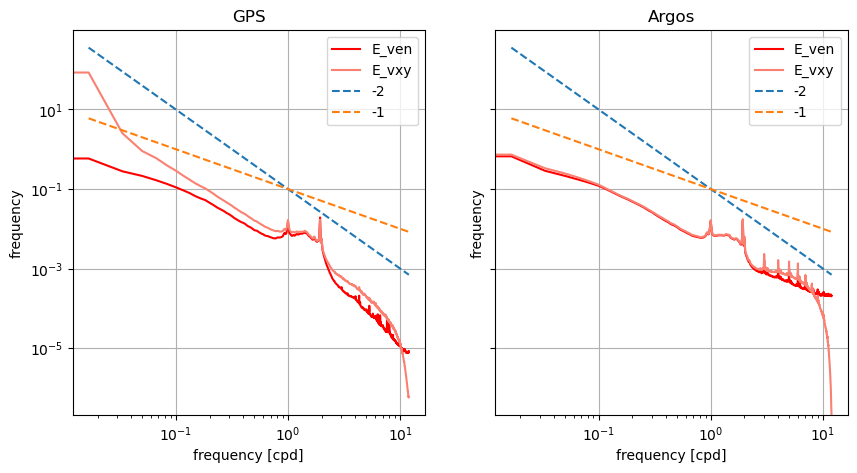

In [4]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax = ax.flatten()

dsg.E_ven.mean(["lon_bins", "lat_bins"]).plot(label="E_ven", color="red", ax=ax[0])
dsg.E_vxy.mean(["lon_bins", "lat_bins"]).plot(label="E_vxy", color="salmon", ax=ax[0])

dsa.E_ven.mean(["lon_bins", "lat_bins"]).plot(label="E_ven", color="red", ax=ax[1])
dsa.E_vxy.mean(["lon_bins", "lat_bins"]).plot(label="E_vxy", color="salmon", ax=ax[1])
for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_ylabel(r"log(E vitesse $[m^2/s^2/cpd]$)")
    a.set_xscale("log")
    a.set_yscale("log")
    (1 / dsa.frequency**2 * 1e-1).plot(ax=a, label="-2", ls="--")
    (1 / dsa.frequency * 1e-1).plot(ax=a, label="-1", ls="--")
    a.legend()

ax[0].set_title("GPS")
ax[1].set_title("Argos")

In [5]:
dsg.E_ven

<xarray.DataArray 'E_ven' (lon_bins: 180, lat_bins: 90, frequency: 1440)>
dask.array<open_dataset-a29a11820145c7b827406def0d5dca94E_ven, shape=(180, 90, 1440), dtype=float64, chunksize=(23, 23, 360), chunktype=numpy.ndarray>
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon_bins   (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Attributes:
    description:  LOWESS method
    long_name:    Power density spectra v = ve + jvn
    units:        $m^2/s^2/cpd$

In [6]:
dsa

<xarray.Dataset>
Dimensions:     (lon_bins: 180, lat_bins: 90, frequency: 1440)
Coordinates:
  * frequency   (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins    (lat_bins) float64 -89.0 -87.0 -85.0 -83.0 ... 85.0 87.0 89.0
  * lon_bins    (lon_bins) float64 -179.0 -177.0 -175.0 ... 175.0 177.0 179.0
Data variables:
    E_aen       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_axy       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_ven       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_venw2     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxy       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxydiff   (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    E_vxyw2     (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(23, 23, 360), meta=np.ndarray>
    nb_geobins  (lon_bins, lat_bins) int64 dask.array<chunksize=(180, 90), meta=np.ndarray>

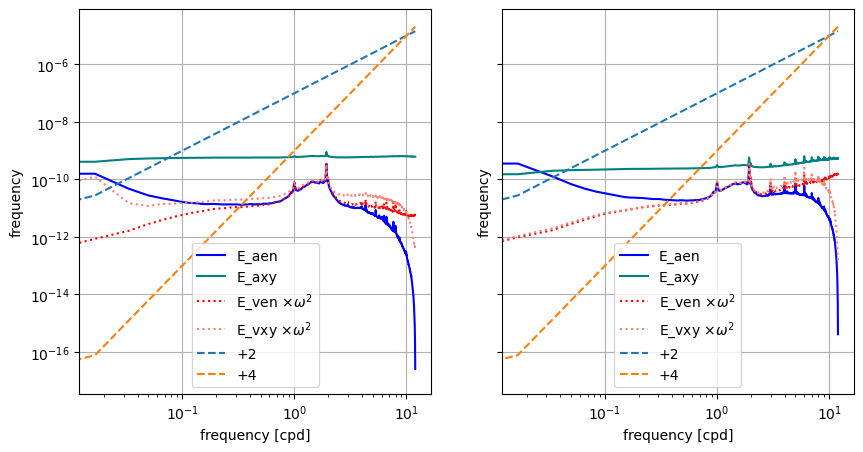

In [7]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
ax = ax.flatten()

dsg.E_aen.mean(["lon_bins", "lat_bins"]).plot(label="E_aen", color="b", ax=ax[0])
dsg.E_axy.mean(["lon_bins", "lat_bins"]).plot(label="E_axy", color="teal", ax=ax[0])
dsg.E_venw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_ven $ \times \omega^2$", color="red", ls=":", ax=ax[0]
)
dsg.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_vxy $ \times \omega^2$", color="salmon", ls=":", ax=ax[0]
)

dsa.E_aen.mean(["lon_bins", "lat_bins"]).plot(label="E_aen", color="b", ax=ax[1])
dsa.E_axy.mean(["lon_bins", "lat_bins"]).plot(label="E_axy", color="teal", ax=ax[1])
dsa.E_venw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_ven $ \times \omega^2$", color="red", ls=":", ax=ax[1]
)
dsa.E_vxyw2.mean(["lon_bins", "lat_bins"]).plot(
    label=r"E_vxy $ \times \omega^2$", color="salmon", ls=":", ax=ax[1]
)

for a in ax:
    a.grid()
    a.set_xlabel("Frequency [cpd]")
    a.set_ylabel(r"log(E acceleration $[m^2/s^4/cpd]$)")
    a.set_xscale("log")
    a.set_yscale("log")
    (dsa.frequency**2 * 1e-7).plot(ax=a, label="+2", ls="--")
    (dsa.frequency**4 * 1e-9).plot(ax=a, label="+4", ls="--")
    a.legend()

In [8]:
cluster.close()

/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:237: FutureWarning: extra has been renamed to worker_extra_args. You are still using it (even if only set to []; please also check config files). If you did not set worker_extra_args yet, extra will be respected for now, but it will be removed in a future release. If you already set worker_extra_args, extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.miniconda3/envs/mdenv/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/home1/datahome/mdemol/.min